# Laplace Equation on a Disk

We will solve a Laplace equation in a polar coordinate system:

$$
r \frac{\partial u }{\partial r} + r^2 \frac{\partial^2 u }{\partial r^2} + \frac{\partial^2 u }{\partial \theta^2} , \qquad \text{where} \quad r  \in [0,1],  \quad \theta \in [0,2 \pi], 
$$

with the Dirichlet boundary conditions:

$$
u(1, \theta) = cos(\theta)
$$

and the periodic boundary condition:

$$
u(r, \theta + 2 \pi) = u(r, \theta)
$$

The reference solution is $u(r, \theta) = rcos(\theta) $.

## Implementation and Training

First, we import the libraries:

In [17]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import PillowWriter
import datetime
import math

We define $sine$ function, $\pi$ value and the maximum and minimum values of the $\theta$ domain:

In [18]:
cos = torch.cos
sin = torch.sin
pi = math.pi

theta_min = 0
theta_max = 2*pi

Now, we set the parameters of the neural network: it has a structure with 1 input ($x$) and 1 output ($u(x)$), 5000 maximum training steps, 2 hidden layers with 16 neurons each, 40 samples and a target minimum loss value of $10^{-4}$.

In [19]:
inputs = 2
outputs = 1
hn_1 = 32
hn_2 = 32
hn_3 = 32
steps = 0
max_steps = 10000
loss = 10
min_loss = 1e-4
log_each = 500
samples = 100
loss_values = []

In this part, we define a new class implementing the activation function $sin(x)$, due to the oscillatory nature of the solution.

In [20]:
class Sine(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return torch.sin(x)

The multilayer perceptron (MLP) structure is:

In [21]:
mlp = nn.Sequential(
    nn.Linear(inputs,hn_1),
    Sine(),
    nn.Linear(hn_1, hn_2),
    Sine(),
    nn.Linear(hn_2, hn_3),
    Sine(),
    nn.Linear(hn_3, outputs)
)

optimizer = torch.optim.Adam(mlp.parameters())
criterion = nn.MSELoss()
mlp.train()

Sequential(
  (0): Linear(in_features=2, out_features=32, bias=True)
  (1): Sine()
  (2): Linear(in_features=32, out_features=32, bias=True)
  (3): Sine()
  (4): Linear(in_features=32, out_features=32, bias=True)
  (5): Sine()
  (6): Linear(in_features=32, out_features=1, bias=True)
)

In this section, we define a function that calculates the gradients.

In [22]:
def computeGrads(y, x):
    grads, = torch.autograd.grad(y, x, grad_outputs=y.data.new(y.shape).fill_(1), create_graph=True, only_inputs=True)
    return grads

Next, we define the main training loop and the timer:

In [23]:
starttime_train = datetime.datetime.now()
print('----Training Started----')

while steps < max_steps and loss > min_loss:
    r = torch.rand(samples)
    theta = (theta_max - theta_min)*torch.rand(samples)
    X = torch.stack([r, theta], axis=-1)
    X.requires_grad = True
    Y = mlp(X)
    grads = computeGrads(Y, X)
    dudr = grads[:, :1]
    dudtheta = grads[:, 1:]
    grads_r2 = computeGrads(dudr, X)
    d2udr2 = grads_r2[:, :1]
    grads_theta2 = computeGrads(dudtheta, X)
    d2udtheta2 = grads_theta2[:, 1:]
    ode_loss = criterion(r*dudr, (r**2)*d2udr2 + d2udtheta2)

    #boundary condition in r=1
    r1 = torch.ones(samples)
    X_boundary_r1 = torch.stack([r1, theta], axis=-1)
    Y_boundary_r1 = mlp(X_boundary_r1)
    u_boundary_r1 = cos(theta).unsqueeze(1)
    bc_r1_loss = criterion(Y_boundary_r1, u_boundary_r1)

    #periodic boundary conditions
    X_boundary_periodic1 = torch.stack([r, theta], axis=-1)
    Y_boundary_periodic1 = mlp(X_boundary_periodic1)

    theta_2pi = (theta_max - theta_min)*torch.rand(samples) + 2*pi
    X_boundary_periodic2 = torch.stack([r, theta_2pi], axis=-1)
    Y_boundary_periodic2 = mlp(X_boundary_periodic2)

    bc_periodic_loss = criterion(Y_boundary_periodic1, Y_boundary_periodic2)
    
    bc_loss = bc_r1_loss + bc_periodic_loss

    optimizer.zero_grad()
    loss = ode_loss + bc_loss
    loss.backward()
    optimizer.step()

    loss_values.append(loss.detach().numpy())

    if steps % log_each == 0:
        print(f'Step:{steps}| ode_loss {ode_loss.item():.5f} bc_loss {bc_loss.item():.5f}')

    steps+=1

endtime_train = datetime.datetime.now()
train_time = endtime_train - starttime_train
train_time_formatted = train_time.seconds + train_time.microseconds / 1e6
print('---Training Finished---')

print(f'Training Duration: {steps} steps in {train_time_formatted:.3f} seconds')

----Training Started----
Step:0| ode_loss 0.00245 bc_loss 0.54189
Step:500| ode_loss 0.03952 bc_loss 0.11463
Step:1000| ode_loss 0.03422 bc_loss 0.09600
Step:1500| ode_loss 0.02594 bc_loss 0.08720
Step:2000| ode_loss 0.03234 bc_loss 0.07898
Step:2500| ode_loss 0.03518 bc_loss 0.10658
Step:3000| ode_loss 0.02786 bc_loss 0.08869
Step:3500| ode_loss 0.02891 bc_loss 0.10501
Step:4000| ode_loss 0.03251 bc_loss 0.08847
Step:4500| ode_loss 0.03925 bc_loss 0.09719
Step:5000| ode_loss 0.02779 bc_loss 0.09598
Step:5500| ode_loss 0.02885 bc_loss 0.09972
Step:6000| ode_loss 0.03615 bc_loss 0.12345
Step:6500| ode_loss 0.02978 bc_loss 0.08212
Step:7000| ode_loss 0.02273 bc_loss 0.07218
Step:7500| ode_loss 0.03662 bc_loss 0.09436
Step:8000| ode_loss 0.02408 bc_loss 0.09219
Step:8500| ode_loss 0.03823 bc_loss 0.10436
Step:9000| ode_loss 0.02717 bc_loss 0.10785
Step:9500| ode_loss 0.04304 bc_loss 0.10593
---Training Finished---
Training Duration: 10000 steps in 32.803 seconds


## Visualization

To visualize the model and compare results, we obtain the output of the trained model and plot it alongside the exact solution.

ValueError: only one element tensors can be converted to Python scalars

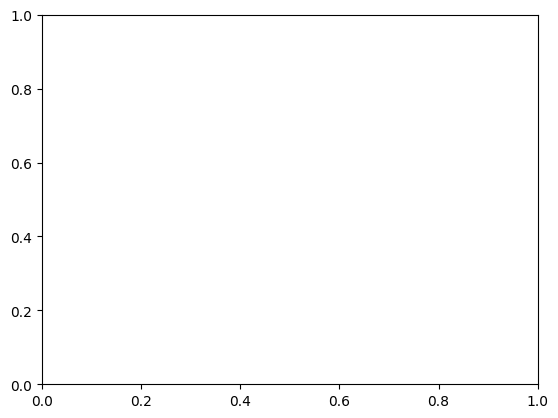

In [24]:
r = torch.linspace(0, 1, samples)
theta = torch.linspace(theta_min, theta_max, samples)

R, Theta = torch.meshgrid(r, theta)

U = R*cos(Theta)

with torch.no_grad():
    X = torch.stack([R, Theta], axis=-1)
    Y = mlp(X)

result = Y.detach().numpy()

# Convert to Cartesian coordinates for plotting
X = R * cos(Theta)
Y = R * sin(Theta)

plt.figure()
plt.pcolormesh(X, Y, U, shading='auto', cmap='viridis')
plt.colorbar(label='u(r, θ)')
plt.title(r'$u(r, \theta) = r \cos(\theta)$')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.tight_layout()

plt.figure()
plt.pcolormesh(X, Y, result, shading='auto', cmap='viridis')
plt.colorbar(label='u(r, θ)')
plt.title(r'$u(r, \theta) = r \cos(\theta)$ PINN')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.tight_layout()

/var/folders/55/nxljtpms2tj44t57c3rg8bfr0000gn/T/ipykernel_52473/3706898892.py:15: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(X, Y, U, shading='auto', cmap='viridis')


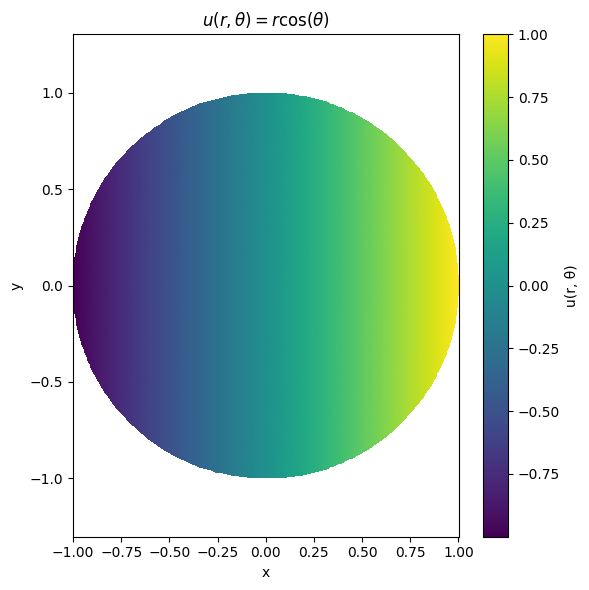

In [ ]:
# Crear malla en coordenadas polares
r = np.linspace(0, 1, 300)
theta = np.linspace(0, 2 * np.pi, 300)
R, Theta = np.meshgrid(r, theta)

# Definir u(r, theta) = r cos(theta)
U = R * np.cos(Theta)

# Convertir a coordenadas cartesianas para graficar
X = R * np.cos(Theta)
Y = R * np.sin(Theta)

# Graficar
plt.figure(figsize=(6, 6))
plt.pcolormesh(X, Y, U, shading='auto', cmap='viridis')
plt.colorbar(label='u(r, θ)')
plt.title(r'$u(r, \theta) = r \cos(\theta)$')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.tight_layout()